<h1> Trabalho Interdisciplinar <h1>

Implementação de um ETL/pipeline de dados, na AWS, utilizando jupyter Notebook para fazer análise dos dados e criando um modelo de classificação.

O trabalho pode ser visto no AWS Lab do Gabriel.

### Participantes:
 - Beatriz Andrade Luiz  - CP3016307
 - Gabriel Marques Molonhoni - CP3016129

 ## 1. Introdução
 
 Este trabalho tem o objetivo de cirar um pipeline de um classificador, onde deseja se classificar pacientes com diabetes ou sem diabetes.
 
 O dataset pode ser visto através dete link: https://www.kaggle.com/datasets/mathchi/diabetes-data-set
 
 Este dataset é original do National Institute of Diabetes and Digestive and Kidney Diseases.
 
 Conteúdo:
  * Pregnancies:número de vezes que  pessoa teve gravidez
  * Glucose: Concentração de glicose no plasma em 2h no teste de tolelrância a glicose
  * BloodPressure: Pressão sanguínea (mm Hg)
  * SkinThickness: Epessura da pele no tríceps (mm)
  * Insulin: Serum de insulina de 2 horas (mu U/ml)
  * BMI: Índice de massa corporal (weight in kg/(height in m)^2)
  * DiabetesPedigreeFunction: Diabetes pedigree function
  * Age: Idade (anos)
  * Outcome: Resultado: 1 se a pessoa tem diabete, 0 em caso negativo
 

## 1.1 Arquitetura

![title](arquitetura_aws.jpg)

## 2. Conectando com AWS

Abaixo é possível ver a conexão com AWS através da biblioteca sagemaker

In [1]:
import boto3
import sagemaker
import os, sys

print (sagemaker.__version__)

session   = sagemaker.Session()
bucket = session.default_bucket()                     
prefix = 'sagemaker/DEMO-projeto-interdisciplinar'
region = boto3.Session().region_name
print(region)

# Role when working on a notebook instance
role = sagemaker.get_execution_role()
print(role)

2.116.0
us-east-1
arn:aws:iam::278225481415:role/LabRole


## 2.1 Criação do Bucket no S3

#### Executar somente se não houver criado o bucket no S3

Este bucket foi criado e adicionado manualmente a base de dados CSV nele.

In [2]:
bucket_name = 'sagemaker-pi-betriz-gabriel'
s3 = boto3.resource('s3')

try:
    if region == 'us-east-1':
        s3.create_bucket(Bucket=bucket_name)
    else:
        s3.create_bucket(Bucket=bucket_name, CreateBucketConfiguration={ 'LocationConstraint': region})
    
    print('S3 Bucket created sucessfully!')
except Exception as e:
    print('S3 error: ', e)
        

S3 Bucket created sucessfully!


## 3. Download dos dados do S3

In [3]:
import pandas as pd

try:
    data = pd.read_csv('s3://sagemaker-pi-betriz-gabriel/datasets/diabetes.csv')
    print('Data downloaded from S3 sucessfully!')
except Exception as e:
    print('Error downloading data')


Data downloaded from S3 sucessfully!


## 4. Análise dos dados

Com os dados baixados, estamos usando um dataframe do Pandas.

## 4.1 Breve análise dos dados

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Observamos que que há 9 colunas, onde os dados são númericos e não há nenhum valor nulo.

In [5]:
data.duplicated().any()

False

Também foi verificado se há algum dado duplicado, felizmente não havia nenhum dado duplicado.

In [6]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Olhando os dados mais profundamente, podemos observar que há várias colunas onde o valor mínimo é 0. Isso pode ser um valor real, mas também pode ser indicativo de um valor faltante, por isso é necessário uma análise melhor.

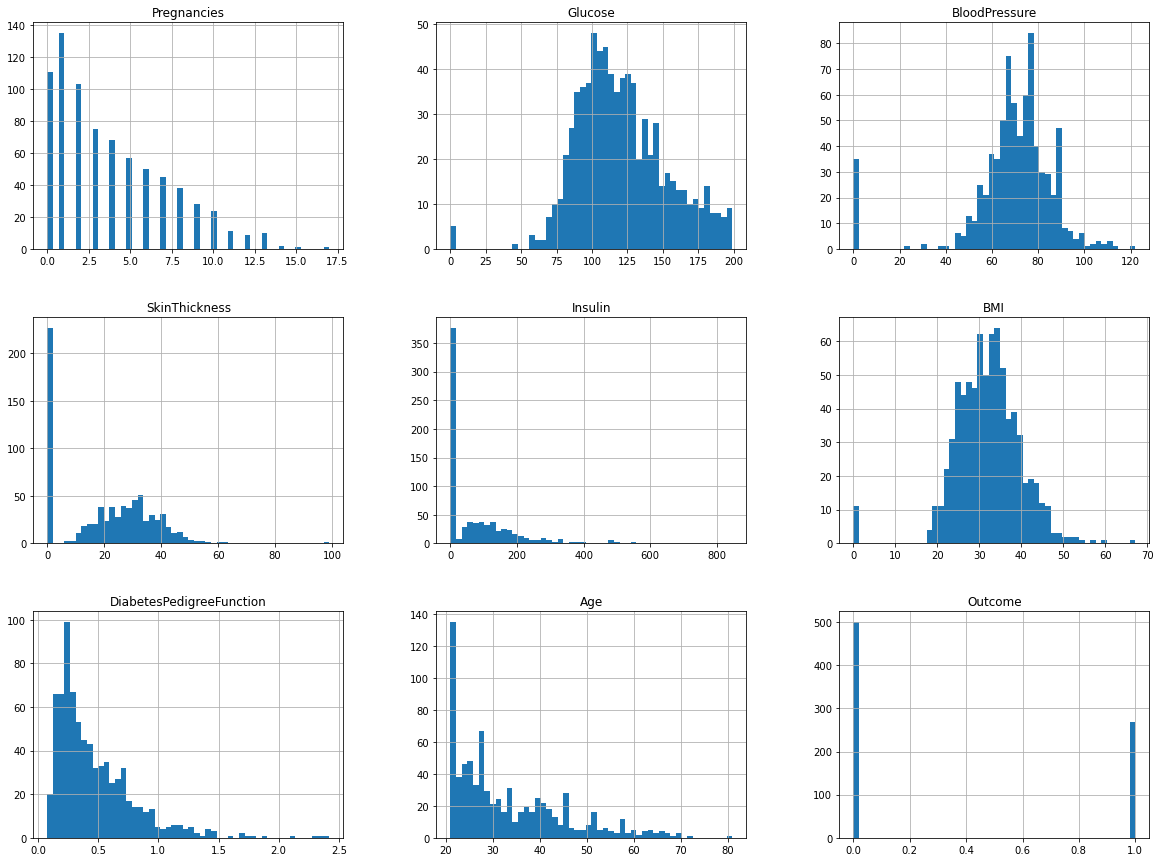

In [7]:
# plot a histogram for each numeric attibute from the dataframe
data.hist(bins=50, figsize=(20,15))
display()  # just to avoid texts in the notebook output

Com a análise mais aprofundada dos gráficos e dos dados, podemos ter alguns Insights:

    * Gravidez 0 indica que a pessoa não teve gravidez - o que faz sentido
    * Glicose 0, como há poucos dados com 0, iremos removê-los.
    * Pressão sanguínea com 0 também não faz sentido, portanto iremos removê-los
    * Espessura da pele 0 não faz muito sentido, porém há muitos dados com 0, então não dá pra remover esses dados
    * insulina 0, pode indicar que a pessoa não toma insulina, mas não dá pra ter certeza sobre isso.
    * BMI (IMC) 0 é impossível, então provavelmente é dado faltante, iremos removê-los futuramente.
    
    

## 5. Tratamento dos dados

In [8]:
#data['Outcome'] = data['Outcome'].astype('bool')
#data.info()

Iremos remover os dados com 0 onde não fazem muito sentido ou há poucos dados relevantes.

In [9]:
data_clean = data.copy()
data_clean = data.loc[~((data['Glucose'] == 0) | (data['BloodPressure'] == 0) | 
                        (data['BMI'] == 0) | (data['DiabetesPedigreeFunction'] == 0))]
data_clean.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000
mean,3.866022,121.882597,72.400552,21.443370,84.494475,32.467127,0.474765,33.350829,0.343923
std,3.362803,30.750030,12.379870,15.732756,117.016513,6.888941,0.332315,11.765393,0.475344
min,0.000000,44.000000,24.000000,0.000000,0.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,0.000000,0.000000,27.500000,0.245000,24.000000,0.000000
50%,3.000000,117.000000,72.000000,24.000000,48.000000,32.400000,0.379000,29.000000,0.000000
75%,6.000000,142.000000,80.000000,33.000000,130.500000,36.600000,0.627500,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Também foram criadas 3 colunas com dados categróricos:
    
    * Gravidez : divido em - 0, 1 e 2+
    * Idade: dividido entre 18 e 40, 40 e 60, 60+
    * IMC: dividido em 0 e 18.5 (baixo), 18.5 e 25 (normal), 25 e 30 (acima do peso), 30 a 35 (obesidade) e 35+ (obesidade extrema)

In [10]:
import numpy as np
import warnings
warnings.simplefilter('ignore')

data_clean['Pregnancie_Stratified'] = pd.cut(data_clean['Pregnancies'], bins=[0, 1, 2, np.inf],
                                        labels=["No child","1 child", "2+ children"], include_lowest=True)

data_clean['Age_Stratified'] = pd.cut(data_clean['Age'], bins=[18, 40, 60, np.inf],
                                        labels=["Young Adult","Adult", "Old"], include_lowest=True)

data_clean['BMI_Stratified'] = pd.cut(data_clean['BMI'], bins=[0, 18.5, 25 ,30, 35, np.inf],
                                        labels=["Low","Normal", "Overweight", "Obesity", "Extreme Obesity"], include_lowest=True)


In [11]:
data_clean.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Pregnancie_Stratified,Age_Stratified,BMI_Stratified
0,6,148,72,35,0,33.6,0.627,50,1,2+ children,Adult,Obesity
1,1,85,66,29,0,26.6,0.351,31,0,No child,Young Adult,Overweight
2,8,183,64,0,0,23.3,0.672,32,1,2+ children,Young Adult,Normal
3,1,89,66,23,94,28.1,0.167,21,0,No child,Young Adult,Overweight
4,0,137,40,35,168,43.1,2.288,33,1,No child,Young Adult,Extreme Obesity


Verificando distribuição das novas colunas

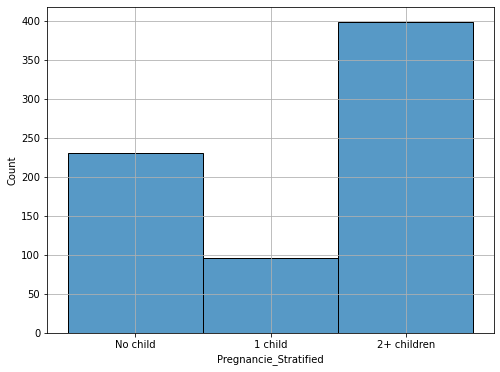

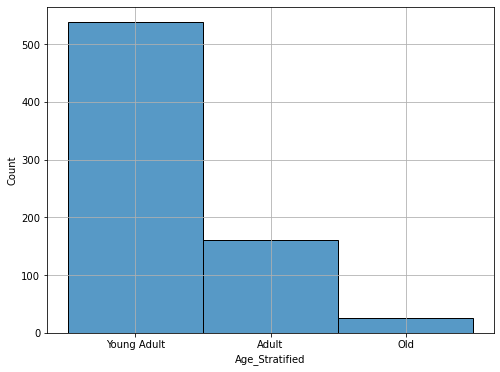

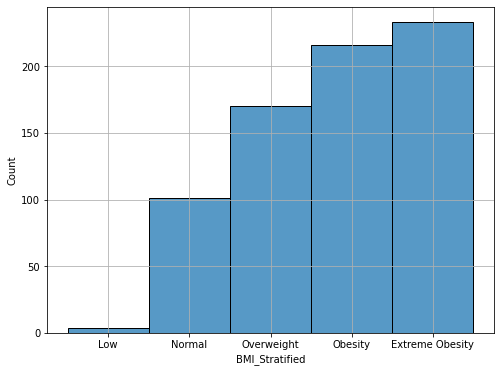

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.histplot(data_clean['Pregnancie_Stratified'])
plt.grid(True)

plt.figure(figsize=(8, 6))
sns.histplot(data_clean['Age_Stratified'])
plt.grid(True)

plt.figure(figsize=(8, 6))
sns.histplot(data_clean['BMI_Stratified'])
plt.grid(True)

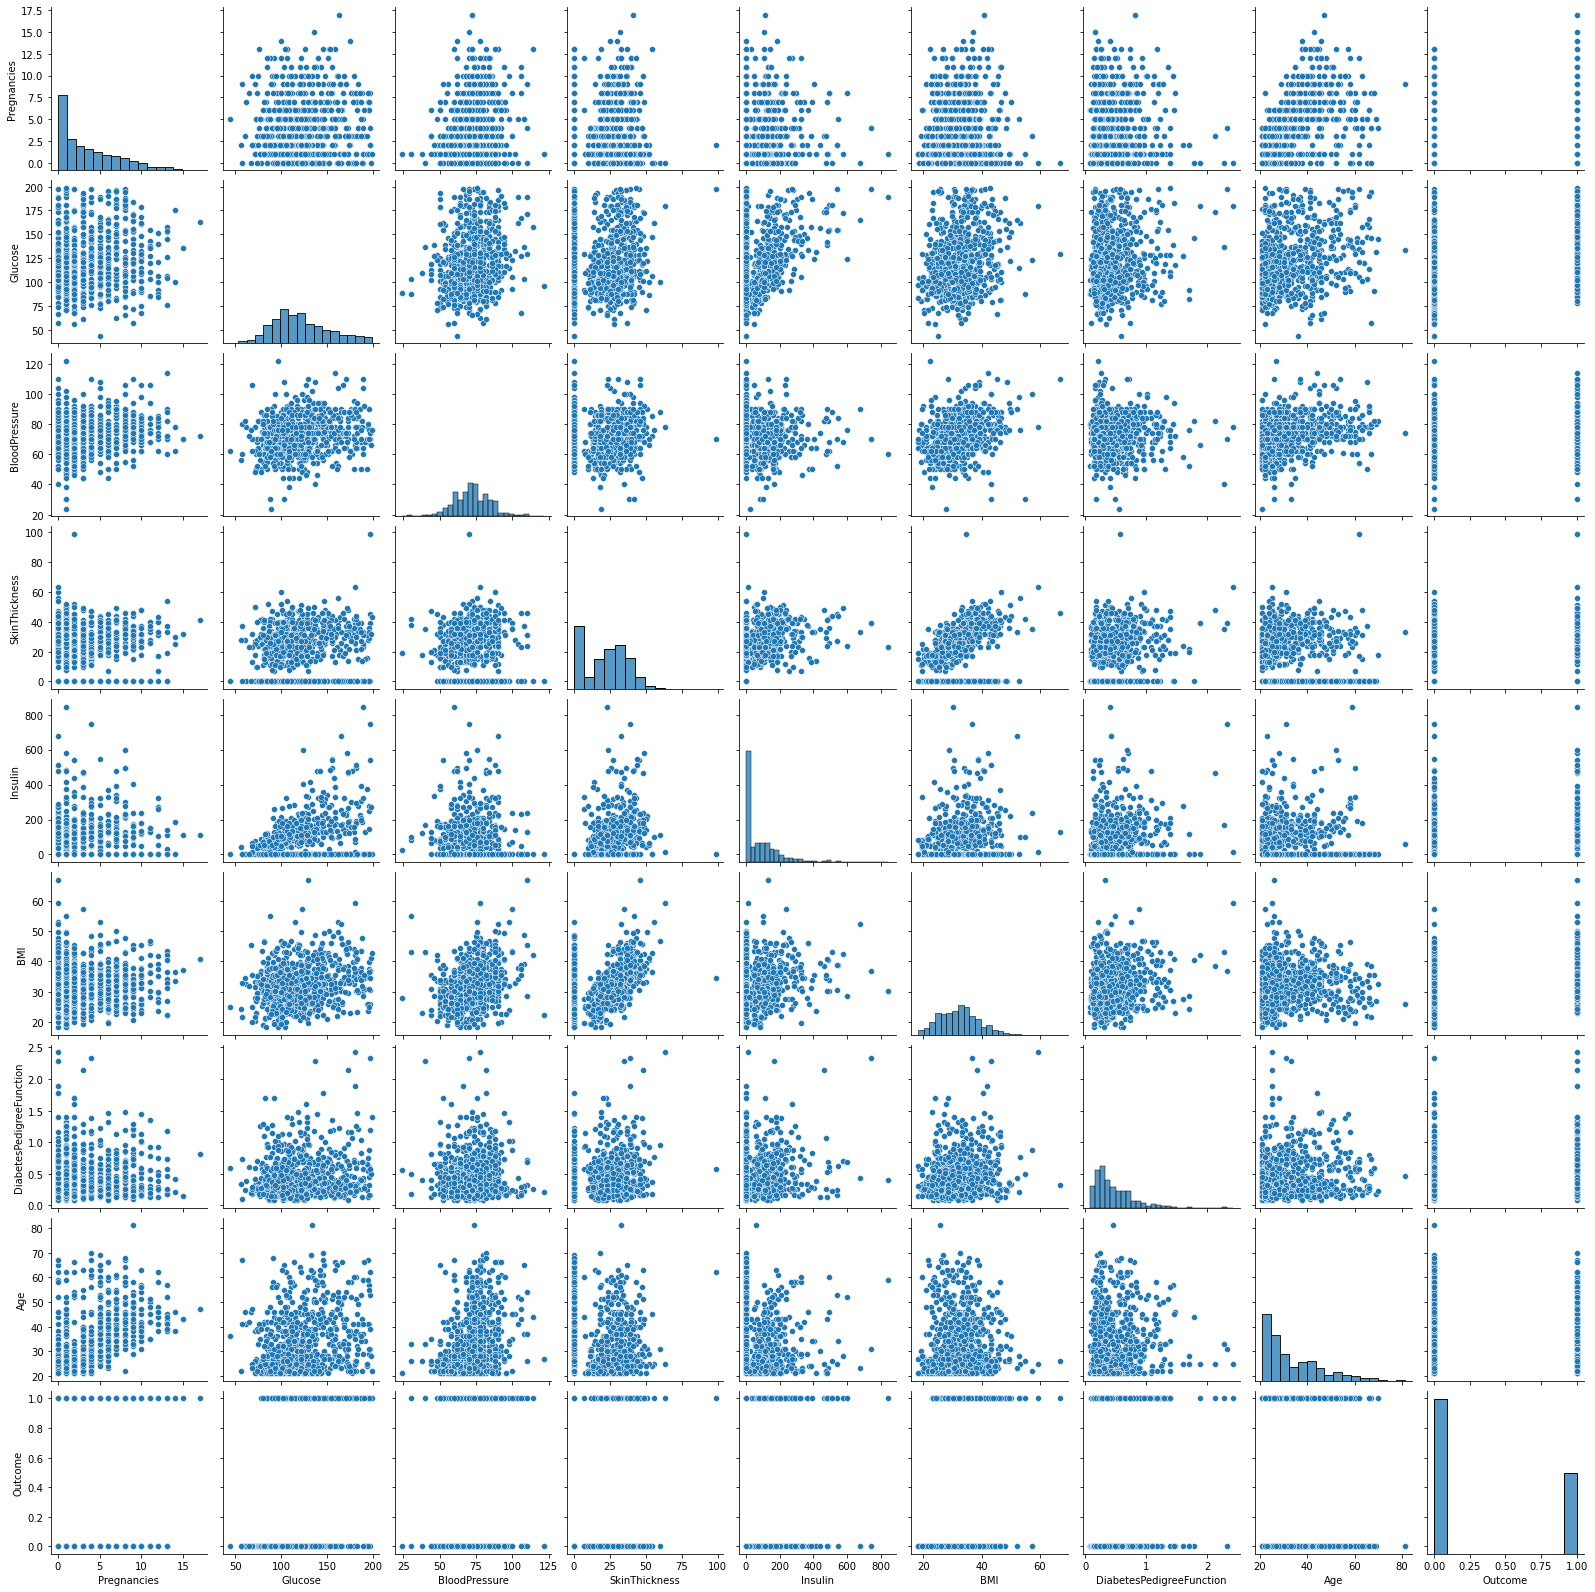

In [13]:
sns.pairplot(data=data_clean)

## 6. Dividindo dataset em treino e validação

In [14]:
from sklearn.model_selection import train_test_split

y_column = 'Outcome'
y = data_clean[y_column]

X = data_clean[data_clean.columns.drop(y_column)]
print(y.shape)
print(X.shape)

data_train, data_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=data_clean[['Pregnancie_Stratified', 'BMI_Stratified']], random_state=42)
print(y_train.shape)
print(data_train.shape)

(724,)
(724, 11)
(543,)
(543, 11)


In [15]:
data_train.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Pregnancie_Stratified',
       'Age_Stratified', 'BMI_Stratified'],
      dtype='object')

## 6.1 Separando em features numéricas e categóricas

In [16]:
# numerical variables
num_vars = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 
            'DiabetesPedigreeFunction', 'Age']

# categorical variables
cat_vars = ['Pregnancie_Stratified', 'Age_Stratified', 'BMI_Stratified']

 Plotando os gráficos tratados das features numéricas

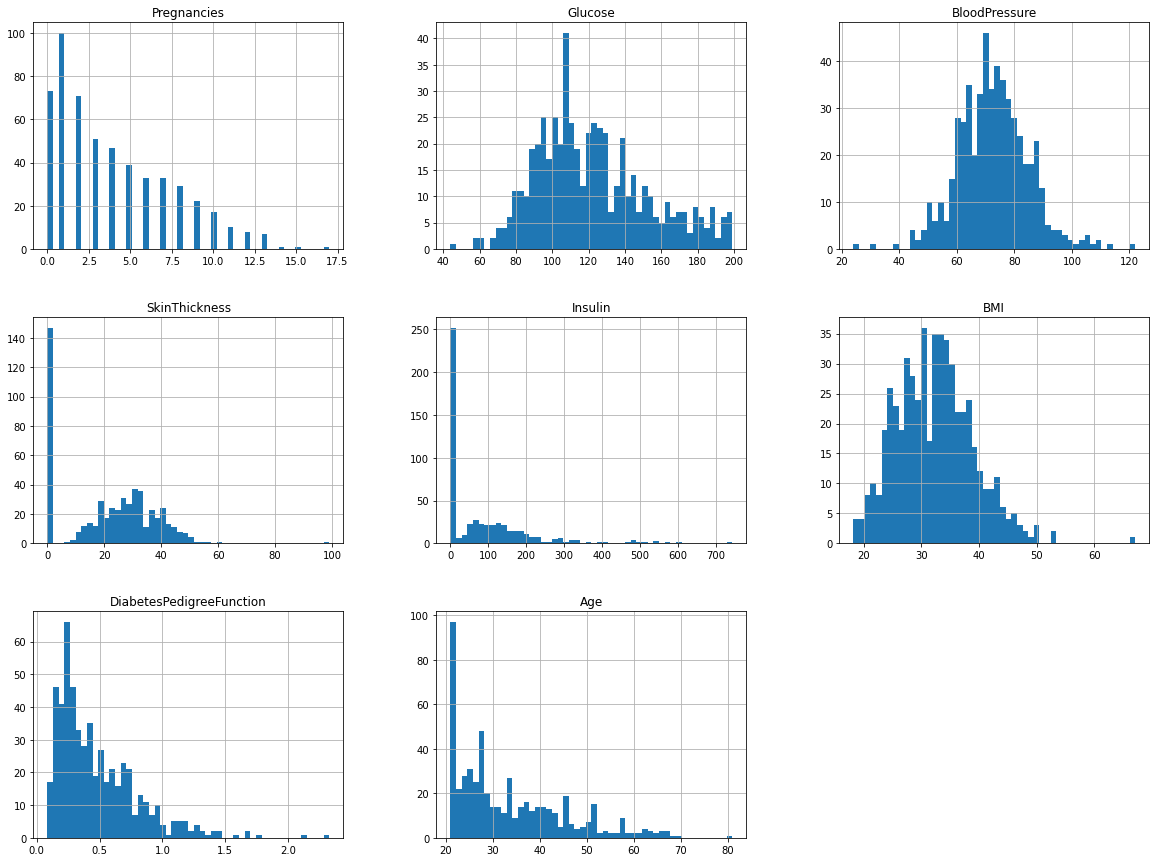

In [17]:
# plot a histogram for each numeric attibute from the dataframe
data_train.hist(bins=50, figsize=(20,15))
display()  # just to avoid texts in the notebook output

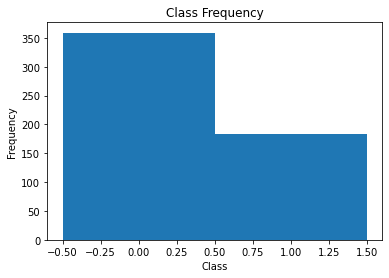

[0 1]
[359 184]


In [18]:
unique, counts = np.unique(y_train, return_counts=True)
plt.bar(unique, counts, 1)
plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

print(unique)
print(counts)

## 6.2 Procurando correlação entre os dados

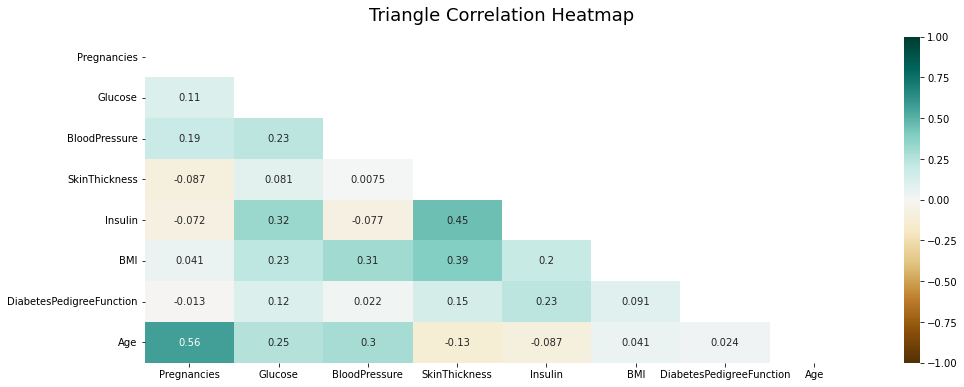

In [19]:
# plotting the correlation coeficients as a heatmap
plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(data_train.corr(), dtype=np.bool))  # creates a triangular matrix based on the pandas correlation matrix

heatmap = sns.heatmap(data_train.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

Como podemos ver, não há uma grnde correlação entre os dados numéricos

## 6.3 Olhando os outliers

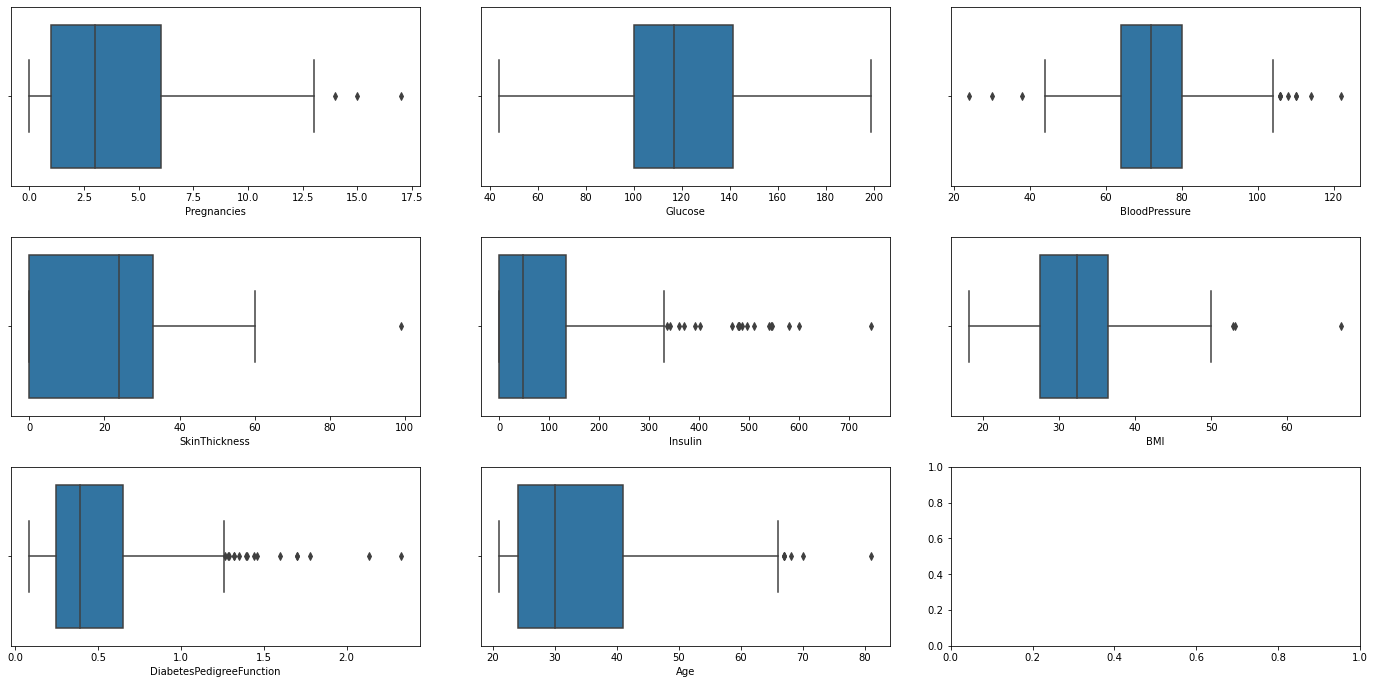

In [20]:
fig, axes = plt.subplots(3, 3, figsize=(20, 10))
fig.tight_layout(pad=3.0)

for i, attr in enumerate(data_train[num_vars].columns):
    row = i // 3
    col = i % 3
    sns.boxplot(data=data_train, x=attr, ax=axes[row, col])

Há alguns outlers em algumas features, porém não iremos removê-los neste momento

## 7. Criando Pipeline de Preprocessamento

Preprocessing padrão (não muito bom para polinomiais)

In [21]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('robust_scaler', RobustScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # as the categories are numbers, we can use the SimpleImputer
    ('one-hot-encoding', OneHotEncoder(handle_unknown='ignore'))
])

# (name, transformer, columns)
preprocessed_pipeline = ColumnTransformer([
    ('numerical', num_pipeline, num_vars),
    ('categorical', cat_pipeline, cat_vars)
])

Preprocessing polinomial

In [22]:
from sklearn.preprocessing import PolynomialFeatures

pol_num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('poly_feat_transformer', PolynomialFeatures(include_bias=False)),  # default degree = 2
    ('robust_scaler', RobustScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # as the categories are numbers, we can use the SimpleImputer
    ('one-hot-encoding', OneHotEncoder(handle_unknown='ignore'))
])


# (name, transformer, columns)
polynomial_preprocessed_pipeline = ColumnTransformer([
    ('numerical', pol_num_pipeline, num_vars),
    ('categorical', cat_pipeline, cat_vars)
])

## 7.1 Aplicando os Pipelines de Pré processamento

In [23]:
# standard pipeline (for KNN and Logistic Regression)
X_train = preprocessed_pipeline.fit_transform(data_train)

# preprocessing pipeline for polynomial-based methods (Polynomial Logistic Regression)
X_train_pol = polynomial_preprocessed_pipeline.fit_transform(data_train)

In [24]:
print(y_train.shape)
print(X_train.shape)
print(X_train_pol.shape)

(543,)
(543, 19)
(543, 55)


## 8. Training the Models

Função para printar os valores de acurácia

In [25]:
# printing function
def display_scores(scores):
    print("Scores:", scores)
    print("\nMean:", scores.mean())
    print("Standard deviation:", scores.std())

## 8.1 KNN

In [26]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()  # default hyperparameters --> k=5
# stratified 10-fold
knn_accs = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')

display_scores(knn_accs)

Scores: [0.76363636 0.67272727 0.8        0.7037037  0.77777778 0.83333333
 0.7962963  0.72222222 0.75925926 0.75925926]

Mean: 0.758821548821549
Standard deviation: 0.04563402649759899


## 8.2 Regressão Linear

In [27]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(random_state=42)
log_reg_accs = cross_val_score(log_reg, X_train, y_train, cv=10, scoring='accuracy')

display_scores(log_reg_accs)

Scores: [0.81818182 0.8        0.81818182 0.72222222 0.75925926 0.88888889
 0.81481481 0.77777778 0.66666667 0.7962963 ]

Mean: 0.7862289562289563
Standard deviation: 0.057341055882152984


## 8.3 Regressão Logística

In [28]:
pol_log_reg = LogisticRegression(random_state=42)
pol_log_reg_accs = cross_val_score(pol_log_reg, X_train_pol, y_train, cv=10, scoring='accuracy')

display_scores(pol_log_reg_accs)

Scores: [0.8        0.76363636 0.8        0.66666667 0.77777778 0.85185185
 0.88888889 0.77777778 0.72222222 0.7962963 ]

Mean: 0.7845117845117846
Standard deviation: 0.05860191737801765


## 8.4 SVM

In [29]:
from sklearn.svm import LinearSVC

svm = LinearSVC()  # C=1.0, loss='squared hinge'
svm_accs = cross_val_score(svm, X_train, y_train, scoring="accuracy", cv=5)

display_scores(svm_accs)

Scores: [0.80733945 0.7706422  0.82568807 0.78703704 0.75      ]

Mean: 0.7881413523615359
Standard deviation: 0.026610245158990537


## 8.5 SVM com Kernel RBF

In [30]:
from sklearn.svm import SVC

svm_rbf = SVC(kernel='rbf')  # C=1.0
svm_rbf_accs = cross_val_score(svm_rbf, X_train, y_train, scoring="accuracy", cv=5, verbose=True)

display_scores(svm_rbf_accs)

Scores: [0.81651376 0.71559633 0.82568807 0.83333333 0.75925926]

Mean: 0.7900781515460414
Standard deviation: 0.04546485363233071


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


## 8.6 Decision Tree

In [31]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt_accs = cross_val_score(dt, X_train, y_train, scoring="accuracy", cv=5)

display_scores(dt_accs)

Scores: [0.74311927 0.70642202 0.69724771 0.75       0.66666667]

Mean: 0.712691131498471
Standard deviation: 0.030704643174246454


## 8.7 Random Forest

In [32]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 500, max_leaf_nodes = 16, oob_score = True, n_jobs = -1, random_state = 42)
rf_accs = cross_val_score(rf, X_train, y_train,cv=5)
# Train the model on training data
display_scores(rf_accs)

Scores: [0.37165322 0.29440624 0.37460499 0.23610994 0.27303566]

Mean: 0.30996200776313854
Standard deviation: 0.05485286707884384


## 8.8 Naive Bayes

### 8.8.1 Gaussian Naive Bayes somente com features numéricas

In [33]:
from sklearn.naive_bayes import GaussianNB

### numerical preprocessing pipeline
num_preprocessing_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('robust_scaler', RobustScaler())
])


### complete preprocessing pipeline
# in this case, we are using it just to filter the desired columns automatically during the full pipeline.
# one could do this manually outside the pipeline
preprocessing_pipeline_1 = ColumnTransformer([
    ('numerical_preprocessing', num_preprocessing_pipeline, num_vars)
])


### naive bayes model = preprocessing + naive bayes classifier
naive_bayes_1 = Pipeline([
    ('preprocessing', preprocessing_pipeline_1),
    ('naive_bayes', GaussianNB())
])


### training naive bayes
naive_bayes_1.fit(data_train, y_train)

naive_bayes_1_accs = cross_val_score(naive_bayes_1, data_train, y_train, scoring="accuracy", cv=10)
display_scores(naive_bayes_1_accs)

Scores: [0.72727273 0.8        0.8        0.68518519 0.7962963  0.77777778
 0.77777778 0.81481481 0.64814815 0.7962963 ]

Mean: 0.7623569023569023
Standard deviation: 0.05347450112876306


### 8.8.2 Categorical Naive Bayes somente com features categóricas

In [34]:
from sklearn.naive_bayes import CategoricalNB
from sklearn.preprocessing import OrdinalEncoder

### categorical preprocessing pipeline
# there will not be OneHotEncoder because the CategoricalNB expects ordinal labels (0, 1, 2, 3, ...)
cat_preprocessing_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # as the categories are numbers, we can use the SimpleImputer
    ('label-enconding', OrdinalEncoder())
])


### complete preprocessing pipeline
# in this case, we are using it just to filter the desired columns automatically during the full pipeline.
# one could do this manually outside the pipeline
preprocessing_pipeline_2 = ColumnTransformer([
    ('categorical_preprocessing', cat_preprocessing_pipeline, cat_vars)
])


### naive bayes model = preprocessing + naive bayes classifier
naive_bayes_2 = Pipeline([
    ('preprocessing', preprocessing_pipeline_2),
    ('naive_bayes', CategoricalNB())
])


### training naive bayes
naive_bayes_2.fit(data_train, y_train)


naive_bayes_2_accs = cross_val_score(naive_bayes_2, data_train, y_train, scoring="accuracy", cv=10)
display_scores(naive_bayes_2_accs)

Scores: [0.72727273 0.69090909 0.74545455 0.7037037  0.7037037  0.7037037
 0.7962963  0.68518519 0.62962963 0.72222222]

Mean: 0.7108080808080808
Standard deviation: 0.04087033122479408


### 8.8.3 Categorical Naive Bayes after converting numerical features to categorical

In [35]:
from sklearn.preprocessing import KBinsDiscretizer

### numerical preprocessing pipeline
# we are using 10 bins but this hyperparameter could be optimized,
# the same for the strategy
num_preprocessing_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('discretization', KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform'))
])


### categorical preprocessing pipeline
# there will not be OneHotEncoder because the CategoricalNB expects ordinal labels (0, 1, 2, 3, ...)
cat_preprocessing_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')) , # as the categories are numbers, we can use the SimpleImputer
    ('label-enconding', OrdinalEncoder())
])


### complete preprocessing pipeline
# in this case, we are using it just to filter the desired columns automatically during the full pipeline.
# one could do this manually outside the pipeline
preprocessing_pipeline_3 = ColumnTransformer([
    ('numerical_preprocessing', num_preprocessing_pipeline, num_vars),
    ('categorical_preprocessing', cat_preprocessing_pipeline, cat_vars)
])


### naive bayes model = preprocessing + naive bayes classifier
naive_bayes_3 = Pipeline([
    ('preprocessing', preprocessing_pipeline_3),
    ('naive_bayes', CategoricalNB())
])


### training naive bayes
naive_bayes_3.fit(data_train, y_train)

naive_bayes_3_accs = cross_val_score(naive_bayes_3, data_train, y_train, scoring="accuracy", cv=10)
display_scores(naive_bayes_3_accs)

Scores: [0.76363636 0.70909091 0.8        0.66666667 0.72222222 0.75925926
 0.81481481 0.7962963  0.66666667 0.77777778]

Mean: 0.7476430976430977
Standard deviation: 0.05115280457875909


## 9. Avaliando os modelos


    | Modelo              | Acurácia (média) | Desvio Padrão
    __________________________________________________________
    
    | KNN                 |   0.7588         | 0.045
    | Regressão Linear    |   0.7862         | 0.057
    | Regressão Logística |   0.7845         | 0.058
    | SVM                 |   0.7863         | 0.024
    | RBF                 |   0.7900         | 0.045
    | Decision Tree       |   0.7126         | 0.030
    | Random Forest  *    |   0.3099         | 0.054   Sem usar scoring acurácia
    | Naive Baye(numerico)|   0.7623         | 0.053
    | Naive Baye(cat)     |   0.7108         | 0.040
    | Naive Baye **       |   0.7476         | 0.0511
    
    
Como podemos ver, a maior acurácia foi com SVM e com RBF, vamos tentar refinar ainda mais estes modelos

## 9.1 Fine Tuning do melhor modelo

Iremos fazer um Grid Search com alguns hiperparametros pré selecionados pra identificar quais são os melhores

In [36]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['linear','rbf', 'poly', 'sigmoid']}

grid = GridSearchCV(SVC(),param_grid)
grid.fit(X_train,y_train)

print(grid.best_estimator_)


SVC(C=100, gamma=0.01)


In [37]:
print(grid.best_params_)

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}


#### Os melhores hiperparametros pra SVM foi:

    * Kernel RBF
    * C = 100
    * Gamma = 0.01
    
    
#### Criando modelo com estes hiperparametros

In [38]:
svm_rbf = SVC(kernel='rbf', C = 100, gamma = 0.01)
svm_rbf_accs = cross_val_score(svm_rbf, X_train, y_train, scoring="accuracy", cv=5, verbose=True)

display_scores(svm_rbf_accs)

Scores: [0.83486239 0.75229358 0.83486239 0.85185185 0.76851852]

Mean: 0.8084777437988446
Standard deviation: 0.04006747319082551


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


Houve uma leve melhora na acurácia, chegando a 80%

#### Tentando balancemanto com uso de pesos

In [39]:
weights = {0:1.90, 1:1.0}
svm_rbf = SVC(kernel='rbf', C = 100, gamma = 0.01, class_weight=weights)
svm_rbf_accs = cross_val_score(svm_rbf, X_train, y_train, scoring="accuracy", cv=5, verbose=True)

display_scores(svm_rbf_accs)

Scores: [0.79816514 0.74311927 0.80733945 0.76851852 0.75925926]

Mean: 0.7752803261977574
Standard deviation: 0.02403427719564498


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


Não houve melhora com uso de pesos no treinamento

#### Tentativa sem as features categóricas

Novo pipeline somente para features numericas

In [40]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('robust_scaler', RobustScaler())
])

preprocessed_pipeline = ColumnTransformer([
    ('numerical', num_pipeline, num_vars),
])

In [41]:
# removendo as features categóricas
data_train_num = data_train[data_train.columns.drop(cat_vars)]
print(data_train_num.columns)

#aplicando pipeline de pré processamento
X_train_num = preprocessed_pipeline.fit_transform(data_train_num)

#treinamento
svm_rbf_accs = cross_val_score(svm_rbf, X_train_num, y_train, scoring="accuracy", cv=5, verbose=True)
display_scores(svm_rbf_accs)

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')
Scores: [0.78899083 0.72477064 0.77981651 0.75925926 0.75925926]

Mean: 0.7624193000339791
Standard deviation: 0.02211832802462147


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


#### Tentativa de remover as categorias numéricas que foram categorizadas

In [42]:
num_vars_new = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'DiabetesPedigreeFunction']

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('robust_scaler', RobustScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('one-hot-encoding', OneHotEncoder(handle_unknown='ignore'))
])

preprocessed_pipeline = ColumnTransformer([
    ('numerical', num_pipeline, num_vars_new),
    ('categorical', cat_pipeline, cat_vars)
])

In [43]:
#variáveis que vão ser removidas
remove_vars = ['Pregnancies', 'Age', 'BMI']

#removendo as colunas
data_train_cat = data_train[data_train.columns.drop(remove_vars)]
print(data_train_cat.columns)

#aplicando pré processamento
X_train_cat = preprocessed_pipeline.fit_transform(data_train_cat)

#treinamento
svm_rbf_accs = cross_val_score(svm_rbf, X_train_cat, y_train, scoring="accuracy", cv=5, verbose=True)
display_scores(svm_rbf_accs)

Index(['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'DiabetesPedigreeFunction', 'Pregnancie_Stratified', 'Age_Stratified',
       'BMI_Stratified'],
      dtype='object')
Scores: [0.77981651 0.7706422  0.78899083 0.74074074 0.75925926]

Mean: 0.7678899082568809
Standard deviation: 0.01677279436575216


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


### Estratégias para melhorar ainda mais
* Adicionar ou remover feature
* Remover Outliers
* Aplicar Transformações

## 10. Avaliando com conjunto de teste

Aplicando pré processamento no conjunto de test

In [44]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('robust_scaler', RobustScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('one-hot-encoding', OneHotEncoder(handle_unknown='ignore'))
])

preprocessed_pipeline = ColumnTransformer([
    ('numerical', num_pipeline, num_vars),
    ('categorical', cat_pipeline, cat_vars)
])

In [45]:
X_test = preprocessed_pipeline.fit_transform(data_test)

In [46]:
from sklearn.metrics import classification_report, confusion_matrix

svm_rbf = SVC(kernel='rbf', C = 100, gamma = 0.01)
svm_rbf.fit(X_train, y_train)

y_pred = svm_rbf.predict(X_test)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[102  14]
 [ 29  36]]
              precision    recall  f1-score   support

           0       0.78      0.88      0.83       116
           1       0.72      0.55      0.63        65

    accuracy                           0.76       181
   macro avg       0.75      0.72      0.73       181
weighted avg       0.76      0.76      0.75       181



## AWS

#### Salvando os datasets de treinamento no S3

In [47]:
# training data saved as csv
pd.concat([y_train, data_train], axis=1).to_csv('train.csv', index=False, header=True)
# upload data to s3 bucket under the 'train' folder
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'Datasets/train.csv')).upload_file('train.csv')
s3_input_train = sagemaker.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket_name, prefix), content_type='csv')

pd.concat([y_test, data_test], axis=1).to_csv('test.csv', index=False, header=True)
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'Datasets/test.csv')).upload_file('test.csv')
s3_input_test = sagemaker.TrainingInput(s3_data='s3://{}/{}/test'.format(bucket_name, prefix), content_type='csv')


#### Criando o modelo do SKLearn que o Sagemaker suporta

In [48]:
from sagemaker.sklearn import SKLearn

training_input_path = 's3://{}/{}/Datasets/train.csv'.format(bucket, prefix)
print(training_input_path)

sk_estimator = SKLearn(
    entry_point="train.py",
    role=role,
    instance_count=1,
    instance_type="ml.c5.xlarge",
    py_version="py3",
    framework_version="1.0-1",
    script_mode=True,
)

# Train the estimator
sk_estimator.fit({"train": training_input_path})

s3://sagemaker-us-east-1-278225481415/sagemaker/DEMO-projeto-interdisciplinar/Datasets/train.csv
2022-11-19 14:29:30 Starting - Starting the training job...
2022-11-19 14:29:46 Starting - Preparing the instances for trainingProfilerReport-1668868169: InProgress
......
2022-11-19 14:30:58 Downloading - Downloading input data......
2022-11-19 14:31:58 Training - Training image download completed. Training in progress.
2022-11-19 14:31:58 Uploading - Uploading generated training model2022-11-19 14:31:48,723 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2022-11-19 14:31:48,725 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-11-19 14:31:48,732 sagemaker_sklearn_container.training INFO     Invoking user training script.
2022-11-19 14:31:49,080 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-11-19 14:31:49,090 sagemaker-training-toolkit INFO     No GPUs detected (normal if n

#### Deploy do modelo no endpoint

In [49]:
import time

sk_endpoint_name = "sklearn-svm-rbf-model" + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
sk_predictor = sk_estimator.deploy(
    initial_instance_count=1, instance_type="ml.m5.large", endpoint_name=sk_endpoint_name
)

-----!

#### Teste do modelo deployado

In [50]:
import json

# teste do modelo 'local'
test_result_1 = svm_rbf.predict([[-0.5 ,0.95, 0.,-0.07,0.93,-0.69,-0.69,-0.25,0,0,1,0,0,1,0,0,0,0,1]])
test_result_2 = svm_rbf.predict([[0.5 ,0.95, 1.,-0.07,0.93,0.69,0.69,-0.25,0,0,1,0,0,1,0,0,0,0,1]])

client = session.sagemaker_runtime_client

request_body = {"Input": [[-0.5 ,0.95, 0.,-0.07,0.93,-0.69,-0.69,-0.25,0,0,1,0,0,1,0,0,0,0,1]]}
data = json.loads(json.dumps(request_body))
payload = json.dumps(data)

response = client.invoke_endpoint(
    EndpointName=sk_endpoint_name, ContentType="application/json", Body=payload
)
result_1 = json.loads(response["Body"].read().decode())["Output"]

request_body = {"Input": [[0.5 ,0.95, 1.,-0.07,0.93,0.69,0.69,-0.25,0,0,1,0,0,1,0,0,0,0,1]]}
data = json.loads(json.dumps(request_body))
payload = json.dumps(data)

response = client.invoke_endpoint(
    EndpointName=sk_endpoint_name, ContentType="application/json", Body=payload
)
result_2 = json.loads(response["Body"].read().decode())["Output"]

print("Predicted class category on local model  1 {}".format(test_result_1))
print("Predicted class category on local model  2 {}".format(test_result_2))
print("Predicted class category on AWS 1 {}".format(result_1))
print("Predicted class category on AWS 2 {}".format(result_2))

Predicted class category on local model  1 [0]
Predicted class category on local model  2 [1]
Predicted class category on AWS 1 0
Predicted class category on AWS 2 1


### Cleanup do Endpoint

In [51]:
sk_predictor.delete_model()
sk_predictor.delete_endpoint()